In [1]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format (
                                                            '/home/geoffrey_link/GoogleNews-vectors-negative300.bin', 
                                                             binary = True
                                                           )

Using TensorFlow backend.


In [2]:
import nltk
import numpy as np
import pandas as pd

questionpairs_train = pd.read_csv('/home/geoffrey_link/train.csv')

questionpairs_train_labels  = np.zeros(questionpairs_train.shape[0], dtype = np.int)
questionpairs_train_vectors = np.zeros((questionpairs_train.shape[0], 300))

questionpairs_train_list    = []

for i in range(questionpairs_train.shape[0]):

    for word in nltk.word_tokenize(str(questionpairs_train['question1'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_train_list.append(word2vec[word])
        except:
            continue

    for word in nltk.word_tokenize(str(questionpairs_train['question2'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_train_list.append(word2vec[word])
        except:
            continue
            
    questionpairs_train_labels[i]  = questionpairs_train['is_duplicate'].iloc[i]
    questionpairs_train_vectors[i] = np.array(questionpairs_train_list).sum(axis=0)
    questionpairs_train_list       = []

# save memory
del questionpairs_train
del questionpairs_train_list

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

model = Sequential()

model.add(Dense      ( units = 64, input_dim = 300))
model.add(Activation ( 'relu'                     ))
model.add(Dense      ( units = 1                  ))
model.add(Activation ( 'softmax'                  ))

model.compile (
               loss      = keras.losses.binary_crossentropy,
               optimizer = keras.optimizers.SGD (
                                                 lr       = 0.01, 
                                                 momentum = 0.9, 
                                                 nesterov = True
                                                ),
               metrics   = ['accuracy']
              )

model.fit     (
               questionpairs_train_vectors, 
               questionpairs_train_labels, 
               epochs     = 5, 
               batch_size = 32
              )

# save memory
del questionpairs_train_labels
del questionpairs_train_vectors

Epoch 1/5
404290/404290 [==============================] - 18s - loss: 10.0565 - acc: 0.3692        

In [4]:
import nltk
import numpy as np
import pandas as pd

questionpairs_test = pd.read_csv('/home/geoffrey_link/test.csv')

questionpairs_test_list      = []
questionpairs_test_vectors   = np.zeros((questionpairs_test.shape[0], 300))

count = 0

for i in range(questionpairs_test.shape[0]):

    for word in nltk.word_tokenize(str(questionpairs_test['question1'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_test_list.append(word2vec[word])
        except:
            continue

    for word in nltk.word_tokenize(str(questionpairs_test['question2'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_test_list.append(word2vec[word])
        except:
            continue
            
    questionpairs_test_vectors[i] = np.array(questionpairs_test_list).sum(axis=0)
    questionpairs_test_list       = []

# save memory
del questionpairs_test_list

In [5]:
import pandas as pd

prediction_output            = pd.DataFrame()
prediction_output['test_id'] = questionpairs_test['test_id']

# save memory
del questionpairs_test

prediction_data              = model.predict (
                                              questionpairs_test_vectors, 
                                              batch_size=128
                                             )

# save memory
del questionpairs_test_vectors

prediction_output['is_duplicate'] = prediction_data
prediction_output.to_csv('simpleKeras_submission.csv', index=False)

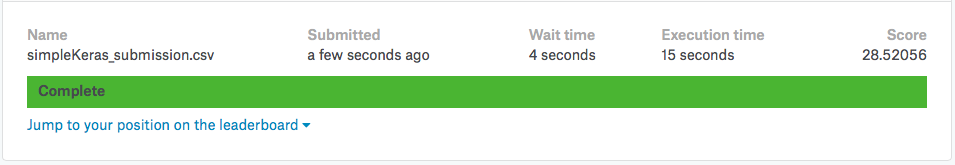

In [4]:
from IPython.display import Image
Image(filename='simpleKeras_submission.png')